# Homework 6
### (Still need to correct Q2 and the write-ups; FourierFit function corrected)

## by Dion Ho


# Import Python Libraries

In [1]:
import numpy as np
import math
import scipy as sc
from scipy.integrate import quad
from scipy import linalg as la
from scipy import sparse
from math import pi
from math import factorial
from matplotlib import pyplot as plt

In [2]:
def rangeE(start,end):
    return range(start,end+1)

## Arnoldi Iteration & GMRES

## Q1

In [3]:
def Arnoldi(b, A, k, tol=1e-8):
    if A.shape[0] != A.shape[1]:
        return "Error, matrix is not square."
    lenb = len(b)
    Q = np.zeros((lenb,k+1), dtype = "cfloat")
    H = np.zeros((k + 1, k), dtype = "cfloat")
    b.shape=(lenb,)
    Q[:,0] = b/np.linalg.norm(b,2)
    for j in rangeE(0,(k-1)):
        Q[:,(j+1)] = A@Q[:,j]
        for i in rangeE(0,j):
            H[i,j] = Q[:,i].conj()@Q[:,(j+1)]
            Q[:,(j+1)] = Q[:,(j+1)] -  H[i,j]*Q[:,i]
        H[j+1,j] = np.linalg.norm(Q[:,(j+1)],2)
        if np.abs(H[j+1,j]) < tol:
            return H[:(j+1),:(j+1)], Q[:,:(j+1)]
        Q[:,(j+1)] = Q[:,(j+1)]/H[j+1,j]
    return H[:(-1),:], Q #In this case Q.shape != H.shape
                         #anyway, even if Q.shape is corrected, most likely H != (Q^H)AQ

Test of Arnoldi function

In [4]:
size = np.random.randint(10,100)
b = np.random.rand(size,1)
A = np.random.rand(size,size)

H,Q = Arnoldi(b,A,100)
np.allclose(H,np.matrix.getH(Q)@A@Q) #Check whether H = (Q^H)AQ

True

## Q2

In [5]:
def GMRES(A, b, x0, k=100, tol=1e-8):
    if A.shape[0] != A.shape[1]:
        return "Error, matrix is not square."
    lenb = len(b)
    Q = np.zeros((lenb,k+1), dtype = "cfloat")
    H = np.zeros((k + 1, k), dtype = "cfloat")
    b.shape = (lenb,)
    x0.shape = (lenb,)
    r0 = b - np.matmul(A,x0)
    beta = np.linalg.norm(r0,2)
    Q[:,0] = r0/beta
    for j in rangeE(0,(k-1)):
        Q[:,j+1] = A@Q[:,j]
        for i in rangeE(0,j):
            H[i,j] = np.transpose(Q[:,i])@Q[:,(j+1)]
            Q[:,(j+1)] = Q[:,(j+1)] - H[i,j]*Q[:,i]
        H[j+1,j] = np.linalg.norm(Q[:,(j+1)],2)
        if np.abs(H[j+1,j]) > tol:
            Q[:,(j+1)] = Q[:,(j+1)]/H[j+1,j]
        e1 = np.zeros(j+2)
        e1[0] = 1
        y,u1,u2,u3 = sc.linalg.lstsq(H[:(j+2),:(j+1)],beta*e1)
        res = np.linalg.norm((H[:(j+2),:(j+1)]@y - beta*e1),2)
        if res < tol:
            print("GMRES: Iterations used =",j)
            return Q[:,:(j+1)]@y + x0, res
    return Q[:,:(j+1)]@y + x0, res

Test of GMRES function

In [6]:
A = np.array([[1,0,0],[0,2,0],[0,0,3]])
b = np.array([1,4,6])
x0 = np.zeros(b.size)
print(GMRES(A,b,x0))

GMRES: Iterations used = 2
(array([1.+0.j, 2.+0.j, 2.+0.j]), 2.77953100530167e-15)


### Bonus: Time comparisons between Jacobian Iteration, Gauss-Seidel, and GMRES

In [7]:
def GMRES_test(A, b, x0, k=100, tol=1e-8):
    if A.shape[0] != A.shape[1]:
        return "Error, matrix is not square."
    lenb = len(b)
    Q = np.zeros((lenb,k+1), dtype = "cfloat")
    H = np.zeros((k + 1, k), dtype = "cfloat")
    b.shape = (lenb,)
    x0.shape = (lenb,)
    r0 = b - np.matmul(A,x0)
    beta = np.linalg.norm(r0,2)
    Q[:,0] = r0/beta
    for j in rangeE(0,(k-1)):
        Q[:,j+1] = A@Q[:,j]
        for i in rangeE(0,j):
            H[i,j] = np.transpose(Q[:,i])@Q[:,(j+1)]
            Q[:,(j+1)] = Q[:,(j+1)] - H[i,j]*Q[:,i]
        H[j+1,j] = np.linalg.norm(Q[:,(j+1)],2)
        if np.abs(H[j+1,j]) > tol:
            Q[:,(j+1)] = Q[:,(j+1)]/H[j+1,j]
        e1 = np.zeros(j+2)
        e1[0] = 1
        y,u1,u2,u3 = sc.linalg.lstsq(H[:(j+2),:(j+1)],beta*e1)
        res = np.linalg.norm((H[:(j+2),:(j+1)]@y - beta*e1),2)
        if res < tol:
            return Q[:,:(j+1)]@y + x0, res
    return Q[:,:(j+1)]@y + x0, res

In [8]:
def diag_dom(n, num_entries=None):
    if num_entries is None:
        num_entries = int(n**1.5) - n
    A = np.zeros((n,n))
    rows = np.random.choice(np.arange(0,n), size=num_entries)
    cols = np.random.choice(np.arange(0,n), size=num_entries)
    data = np.random.randint(-4, 4, size=num_entries)
    for i in range(num_entries):
        A[rows[i], cols[i]] = data[i]
    for i in range(n):
        A[i,i] = np.sum(np.abs(A[i])) + 1
    return A

In [9]:
def jacobian_iteration(A,b,x1,tol=1e-8,maxiter=100,printiter=False):
    if A.shape[0] != A.shape[1]:
        return "Error, matrix is not square."
    m = A.shape[1]
    x1.shape = (m,)
    b.shape = (m,)
    D = np.diag(np.diag(A))
    AA = A - D
    D_inv = np.diag(1/np.diag(A))
    x = D_inv @ (b - (AA @ x1))
    iteration = 1
    residue = la.norm((x1 - x),np.inf)
    #print("iter","   residue")
    #print('{:>3d} {:> 22.16f}'.format(iteration, residue))
    while (residue > tol) & (maxiter >= iteration):
        x1 = x
        x = D_inv @ (b - (AA @ x1))
        residue = la.norm((x1 - x),np.inf)
        iteration += 1
        #print('{:>3d} {:> 22.16f}'.format(iteration, residue))
    if maxiter >= iteration + 1:
        if (printiter):
            print("Jacobian Iteration: Iterations used =",iteration)
        return x
    else:
        print("Failed to converge.")

In [10]:
def gauss_seidel_plot(A,b,x1,plot=False,tol=1e-8,maxiter=100,omega=1,printiter=False):
    if A.shape[0] != A.shape[1]:
        return "Error, matrix is not square."
    m = A.shape[1]
    x1.shape = (m,)
    b.shape = (m,)
    x = np.zeros(np.shape(b))
    for ii in rangeE(0,m-1):
        sum1 = 0
        sum2 = 0
        for jj in rangeE(0,ii-1):
            sum1 += A[ii,jj]*x[jj]
        for jj in rangeE(ii,m-1): #Without omega, this is rangeE(ii+1,m-1)
            sum2 += A[ii,jj]*x1[jj]
        x[ii] = x1[ii] + omega*(b[ii] - sum1 - sum2)/A[ii,ii]
    iteration = 1
    residue = la.norm((x1 - x),np.inf)
    if plot == True:
        res_plt = [residue]
    #else:
        #print("iter","   residue")
        #print('{:>3d} {:> 22.16f}'.format(iteration, residue))
    while (residue > tol) & (maxiter >= iteration):
        x1 = np.copy(x)
        for ii in rangeE(0,m-1):
            sum1 = 0
            sum2 = 0
            for jj in rangeE(0,ii-1):
                sum1 += A[ii,jj]*x[jj]
            for jj in rangeE(ii,m-1):
                sum2 += A[ii,jj]*x1[jj]
            x[ii] = x1[ii] + omega*(b[ii] - sum1 - sum2)/A[ii,ii]
        residue = la.norm((x1 - x),np.inf)
        iteration += 1
        if plot == True:
            res_plt.append(residue)
        #else:
            #print('{:>3d} {:> 22.16f}'.format(iteration, residue))
    if plot == True:
        plt.figure(figsize=(10,5))
        plt.semilogy(rangeE(1,iteration),np.abs(res_plt),'o')
        plt.title('Plot of Residue for Gauss-Seidel Method against Iteration Count',fontsize=18)
        plt.xlabel('Iteration Count',fontsize=14)
        plt.ylabel('Residue',fontsize=14)
    if maxiter >= iteration + 1:
        if (printiter):
            print("Gauss Seidel: Iterations used =",iteration)
        return x
    else:
        print("Failed to converge.")

In [11]:
size = np.random.randint(10,20) #Generate random test data
x = np.random.rand(size,1)
A = diag_dom(size)
b = A @ x
x1 = np.random.rand(size,1)

In [12]:
ans1 = jacobian_iteration(A,b,x1,tol=1e-8,maxiter=100,printiter=True)
ans2 = gauss_seidel_plot(A,b,x1,False,tol=1e-8,maxiter=100,printiter=True)
ans3, res = GMRES(A,b,x1,k=100,tol=1e-8)
np.allclose(ans1,ans2,np.real(ans3))

Jacobian Iteration: Iterations used = 31
Gauss Seidel: Iterations used = 15
GMRES: Iterations used = 13


True

In [13]:
%timeit jacobian_iteration(A,b,x1,tol=1e-8,maxiter=100);
%timeit gauss_seidel_plot(A,b,x1,False,tol=1e-8,maxiter=100);
%timeit ans3, res = GMRES_test(A,b,x1,k=100,tol=1e-8); #GMRES uses fewer iterations though it is slower
                                                       #GMRES can possibly be made faster though (use vectorised code?)

563 µs ± 16.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.85 ms ± 37.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.93 ms ± 101 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Approximations

## Q1(a)

$$\langle \vec{x},\vec{y} \rangle = \sum_{i=1}^n x_i y_i = \sum_{i=1}^n y_i x_i = \langle \vec{y},\vec{x} \rangle.$$

## Q1(b)

$$\frac{d}{dx_j} \langle \vec{x}, \vec{y} \rangle = \frac{d}{dx_j} \sum_{i=1}^n x_i y_i = \sum_{i=1}^n \frac{d}{dx_j}(x_i y_i) = y_j = \langle \vec{e}^{(j)}, \vec{y} \rangle.$$

## Q1(c)

$$\langle \vec{x},A\vec{x} \rangle = \vec{x}^T A\vec{x} = \sum_{i=1}^n \sum_{j=1}^n a_{i,j} x_j x_i.$$

\begin{align}
\frac{d}{dx_k} \langle \vec{x},A\vec{x} \rangle &= \sum_{i=1}^n \sum_{j=1}^n \frac{d}{dx_k} a_{i,j} x_j x_i \\
&= \sum_{i=1}^n a_{i,k} x_i + \sum_{j=1}^n a_{k,j} x_j \\
&=  (A\vec{x})_k + (A^T\vec{x})_k \mbox{ which is the $k$th entry of $(A\vec{x}) + (A^T\vec{x})$}.\\
\end{align}

$$\nabla \langle \vec{x},A\vec{x} \rangle = \left[ \frac{d\langle \vec{x},A\vec{x} \rangle}{dx_1} \hspace{0.5pc} \ldots \hspace{0.5pc} \frac{d\langle \vec{x},A\vec{x} \rangle}{dx_n} \right]^T = \left[ (A\vec{x})_1 + (A^T\vec{x})_1 \hspace{0.5pc} \ldots \hspace{0.5pc} (A\vec{x})_n + (A^T\vec{x})_n \right]^T.$$

Therefore,
$$ \nabla \langle \vec{x},A\vec{x} \rangle = (A\vec{x}) + (A^T\vec{x}) = (A + A^T)\vec{x}.$$

## Q1(d)

$$\frac{d}{dx_j} \langle \vec{x},\vec{x} \rangle = \frac{d}{dx_j} \langle \vec{x},I\vec{x} \rangle = (I + I^T)\vec{x}_j =  (I + I)\vec{x}_j= 2Ix_j = 2x_j.$$

## Q2(a)

$$\frac{d}{da_0} \sum_{i=1}^n ((a_1(dx)_i + a_0 - (dy)_i)^2 = \sum_{i=1}^n 2((a_1(dx)_i + a_0 - (dy)_i).$$
$$\frac{d}{da_1} \sum_{i=1}^n ((a_1(dx)_i + a_0 - (dy)_i)^2 = \sum_{i=1}^n 2((a_1(dx)_i + a_0 - (dy)_i)(dx)_i.$$

We let $\nabla E = 0$ to find the minimum point. $\nabla E = 0 \implies \frac{dE}{da_1} = 0 \mbox{ and } \frac{dE}{da_0}  = 0.$ Therefore,

\begin{align}
&2\sum_{i=1}^n a_0 = 2\sum_{i=1}^n ((dy)_i-a_1(dx)_i) \mbox{ and } 2\sum_{i=1}^n a_0((dx)_i)^2 = 2\sum_{i=1}^n ((dy)_i-a_1(dx)_i)(dx)_i\\
&\implies n a_0 = \sum_{i=1}^n ((dy)_i-a_1(dx)_i) \mbox{ and } a_0\sum_{i=1}^n ((dx)_i)^2 = \sum_{i=1}^n ((dy)_i-a_1(dx)_i)(dx)_i\\
&\implies a_0 = \frac{1}{n}\sum_{i=1}^n ((dy)_i-a_1(dx)_i) = \frac{\sum_{i=1}^n ((dy)_i-a_1(dx)_i)(dx)_i}{\sum_{i=1}^n (dx)_i}.\\
&2\sum_{i=1}^n a_1(dx)_i = 2 \sum_{i=1}^n ((dy)_i - a_0) \mbox{ and } 2\sum_{i=1}^n a_1((dx)_i)^2 = 2 \sum_{i=1}^n ((dy)_i - a_0)(dx)_i\\
&\implies a_1 \sum_{i=1}^n (dx)_i = \sum_{i=1}^n ((dy)_i - a_0) \mbox{ and } a_1 \sum_{i=1}^n ((dx)_i)^2 = \sum_{i=1}^n ((dy)_i - a_0)(dx)_i \\
&\implies a_1 = \frac{\sum_{i=1}^n ((dy)_i - a_0)}{\sum_{i=1}^n (dx)_i} = \frac{\sum_{i=1}^n ((dy)_i - a_0)(dx)_i}{\sum_{i=1}^n ((dx)_i)^2}.
\end{align}

$$\frac{d^2}{da_0^2} \sum_{i=1}^n ((a_1(dx)_i + a_0 - (dy)_i)^2 = 2\sum_{i=1}^n 1 = 2n.$$
$$\frac{d^2}{da_1^2} \sum_{i=1}^n ((a_1(dx)_i + a_0 - (dy)_i)^2 = \sum_{i=1}^n 2((dx)_i)^2 = 2\| dx \|_2^2.$$

Therefore, for $\nabla^2 E > 0$, which implies that $E$ is minimised, we need $\| dx \|_2^2 > 0.$ For there to be a unique solution, $\sum_{i=1}^n (dx)_i \neq 0$ and $n=2$ and $(a_1(dx)_i + a_0 - (dy)_i) \neq \gamma(a_1(dx)_j + a_0 - (dy)_j), \forall \gamma \in \mathbb{R}, \gamma \neq 0, \forall i,j \in \mathbb{N}, i \neq j$.

## Q2(b)

\begin{align}
\langle A\vec{x}-b,A\vec{x}-b \rangle &= \| A\vec{x}-b \|_2^2 = \| a_0 + a_1 \vec{dx}-b \|_2^2 = \| a_0 + a_1 \vec{dx}-\vec{dy}\|_2^2 \\
&= E = \sum_{i=1}^n ((a_1(dx)_i + a_0 - (dy)_i)^2.
\end{align}

## Q2(c)

\begin{align}
\frac{d}{dx_j} \langle A\vec{x}-b,A\vec{x}-b \rangle &= \frac{d}{dx_j} \langle A\vec{x},A\vec{x} \rangle - \frac{d}{dx_j} 2\langle A\vec{x},b \rangle - \frac{d}{dx_j} \langle b,b \rangle \\
&= \frac{d}{dx_j} \langle \vec{x},A^TA\vec{x} \rangle - \frac{d}{dx_j} 2\langle A\vec{x},b \rangle. \\
\end{align}
$$\frac{d}{dx_j} 2\langle A\vec{x}, \vec{b} \rangle = 2\frac{d}{dx_j}(A\vec{x})^T \vec{b} = 2\frac{d}{dx_j}\vec{x}^TA^T \vec{b} = 2\sum_{r=1}^n \sum_{c=1}^n \frac{d}{dx_j} x_c a_{c,r}  b_r = 2\sum_{r=1}^n a_{j,r}  b_r = 2(A^T\vec{b})_j$$
which is the $j$th row of $A^T\vec{b}$.

Therefore,
\begin{align}
\frac{d}{dx} \langle A\vec{x}-b,A\vec{x}-b \rangle &= (A^TA + (A^TA)^T)\vec{x} - 2A^T\vec{b} = (A^TA + A^TA)\vec{x} - 2A^T\vec{b} \\
& = 2A^TA\vec{x} - 2A^T\vec{b}.
\end{align}

$$A^T A\vec{x} = \left(
\begin{array}{cc}
 \sum_{i=1}^{n} 1 & \sum_{i=1}^{n} (dx)_i \\
 \sum_{i=1}^{n} (dx)_i & \sum_{i=1}^{n} ((dx)_i)^2  \\
\end{array}\right)\left(
\begin{array}{c}
 a_0 \\
 a_1
\end{array}\right) = \left(\begin{array}{c}
 na_0 + a_1\sum_{i=1}^{n} (dx)_i \\
 a_0\sum_{i=1}^{n} (dx)_i + a_1\sum_{i=1}^{n} ((dx)_i)^2  \\
\end{array}
\right).$$

$$A^T\vec{b} = \left(
\begin{array}{c} 
 \sum_{i=1}^{n} (dy)_i \\
 \sum_{i=1}^{n} (dx)_i(dy)_i\\
\end{array}\right).$$

Let $\frac{d}{dx} \langle A\vec{x}-b,A\vec{x}-b \rangle$ = 0. Then, $A^T A\vec{x} = A^T\vec{b}$ which implies that
\begin{align}
&a_0 = \frac{1}{n}\sum_{i=1}^n ((dy)_i-a_1(dx)_i) = \frac{\sum_{i=1}^n ((dy)_i-a_1(dx)_i)(dx)_i}{\sum_{i=1}^n (dx)_i}, \\
&a_1 = \frac{\sum_{i=1}^n ((dy)_i - a_0)}{\sum_{i=1}^n (dx)_i} = \frac{\sum_{i=1}^n ((dy)_i - a_0)(dx)_i}{\sum_{i=1}^n ((dx)_i)^2}.
\end{align}

$$\frac{d^2}{dx^2} \langle A\vec{x}-b,A\vec{x}-b \rangle = \frac{d}{dx} 2A^TA\vec{x} = 2\left(\begin{array}{c}
 \frac{d}{da_0} (na_0 + a_1\sum_{i=1}^{n} (dx)_i) \\
 \frac{d}{da_1} (a_0\sum_{i=1}^{n} (dx)_i + a_1\sum_{i=1}^{n} ((dx)_i)^2)  \\
\end{array}
\right) = 2\left(\begin{array}{c}
 n \\
 \sum_{i=1}^{n}((dx)_i)^2
\end{array}\right) = \left(\begin{array}{c}
 2n \\
 2\| dx \|_2^2
\end{array}\right).$$

Therefore, the Inner-Product method produces the same solution for $a_0$ and $a_1$. Moreover, for $\frac{d^2}{dx^2} \langle A\vec{x}-b,A\vec{x}-b \rangle = 0$, which implies that $\langle A\vec{x}-b,A\vec{x}-b \rangle$ is minimised, we need $\| dx \|_2^2 > 0$, which is identical to the condition derived from the Summation method. For there to be a unique solution, $\sum_{i=1}^n (dx)_i \neq 0$ and $A$ is a square matrix with full rank, i.e. it is invertible.

## Q3(a)

Since $\tilde f(x)$ is real, 
\begin{align}
&\tilde f(x) = \overline{\tilde f(x)} \\
&\implies \sum_{n=-N}^N \hat f_n e^{i\omega_n x} = \overline{\sum_{n=-N}^N \hat f_n e^{i\omega_n x}} \\
&\implies \sum_{n=-N}^N \hat f_n e^{i\omega_n x} = \sum_{n=-N}^N \overline{\hat f_n} e^{-i\omega_n x} \\
&\implies \sum_{n=-N}^N \hat f_n e^{i\omega_n x} = \sum_{n=-N}^N \overline{\hat f_n} e^{i\omega_{-n} x} \mbox{ since } \omega = \frac{2n\pi}{L} \\
&\implies \sum_{n=-N}^N \hat f_{-n} e^{i\omega_{-n} x} = \sum_{n=-N}^N \hat f_n e^{i\omega_n x} = \sum_{n=-N}^N \overline{\hat f_n} e^{i\omega_{-n} x} \\
&\implies \hat f_{-n} = \overline{\hat f_n}.
\end{align}

## Q3(b)

\begin{align}
\langle af,g\rangle  &= \int_{\frac{-L}{2}}^{\frac{L}{2}} af(x)\overline{g(x)} dx \\
&= a\int_{\frac{-L}{2}}^{\frac{L}{2}} f(x)\overline{g(x)} dx = a\langle f,g\rangle . \\
\langle f,ag\rangle  &= \int_{\frac{-L}{2}}^{\frac{L}{2}} f(x)\overline{ag(x)} dx \\
&= \overline{a}\int_{\frac{-L}{2}}^{\frac{L}{2}} f(x)\overline{g(x)} dx = \overline{a}\langle f,g\rangle .
\end{align}

## 3(c): $(D^2)$

By the bilinearity of the inner product, $(D)^2 =   \langle f(x) - \tilde f(x), f(x) - \tilde f(x)\rangle    =   \langle f,f\rangle  - \langle f, \tilde f\rangle  - \langle \tilde f, f\rangle  + \langle \tilde f, \tilde f\rangle $.

$$\langle \tilde f, \tilde f\rangle    =   \left\langle \sum_{n=-N}^{N} \hat f_n e^{i\omega_n x}, \sum_{n=-N}^{N} \hat f_n e^{i\omega_n x} \right\rangle .$$

Due to the orthogonality of the exponential Fourier basis, $\langle e^{i\omega_n x}, e^{i\omega_m x}\rangle   = 0$ for all $m \neq n$. Therefore,

\begin{align}
\left\langle \sum_{n=-N}^{N} \hat f_n e^{i\omega_n x}, \sum_{n=-N}^{N} \hat f_n e^{i\omega_n x} \right\rangle    &= \sum_{n=-N}^{N}\langle \hat f_n e^{i\omega_n x}, \hat f_n e^{i\omega_n x}\rangle  \\
&= \sum_{n=-N}^{N}\hat f_n \overline{\hat f_n}\langle e^{i\omega_n x}, e^{i\omega_n x}\rangle  \\
&= \sum_{n=-N}^{N}\hat f_n \hat f_{-n}\langle e^{i\omega_n x}, e^{i\omega_n x}\rangle .
\end{align}

Therefore,
$$(D)^2 =   \langle f,f\rangle  - \langle f, \tilde f\rangle  - \langle \tilde f, f\rangle  + \sum_{n=-N}^{N}\hat f_n \hat f_{-n}\langle e^{i\omega_n x}, e^{i\omega_n x}\rangle .$$

## 3(c): $\displaystyle\frac{d}{d\hat f_j}(D^2)$

$$\frac{d}{d\hat f_j}(D)^2 = \frac{d}{d\hat f_j}\langle f,f\rangle  - \frac{d}{d\hat f_j}\langle f, \tilde f\rangle  - \frac{d}{d\hat f_j}\langle \tilde f, f\rangle  + \frac{d}{d\hat f_j}\left(\sum_{n=-N}^{N}\hat f_n \hat f_{-n}\langle e^{i\omega_n x}, e^{i\omega_n x}\rangle \right).$$

Examining each term, we have
\begin{align}
\frac{d}{d\hat f_j}\langle f, \tilde f\rangle  &= \frac{d}{d\hat f_j}\left(\int_{\frac{-L}{2}}^{\frac{L}{2}} f(x)\overline{\tilde f(x)} dx\right) \\
&= \int_{\frac{-L}{2}}^{\frac{L}{2}} f(x)\frac{d}{d\hat f_j}\left(\overline{\tilde f(x)}\right) dx \\
&= \int_{\frac{-L}{2}}^{\frac{L}{2}} f(x) e^{i\omega_{j} x}dx \\
&= \int_{\frac{-L}{2}}^{\frac{L}{2}} f(x) \overline{e^{-i\omega_{j} x}}dx =   \langle f,e^{-i\omega_{j} x}\rangle . \\
\frac{d}{d\hat f_j}\langle \tilde f, f\rangle  &= \frac{d}{d\hat f_j}\left(\int_{\frac{-L}{2}}^{\frac{L}{2}} \tilde f(x)\overline{f(x)} dx\right) \\
&= \int_{\frac{-L}{2}}^{\frac{L}{2}} \frac{d}{d\hat f_j} \tilde f(x)\overline{f(x)} dx \\
&= \int_{\frac{-L}{2}}^{\frac{L}{2}} e^{i\omega_{j} x} \overline{f(x)} dx =   \langle e^{i\omega_{j}} x,f\rangle .
\end{align}

In addition,
\begin{align}
\frac{d}{d\hat f_j}\left(\sum_{n=-N}^{N}\hat f_n \hat f_{-n}\langle e^{i\omega_n x}, e^{i\omega_n x}\rangle \right) &= (1)\hat f_{-j}\langle e^{i\omega_j x}, e^{i\omega_j x}\rangle  + \hat f_{-j}(1)\langle e^{i\omega_j x}, e^{i\omega_j x}\rangle  \\
&= 2\hat f_{-j}\langle e^{i\omega_j x}, e^{i\omega_j x}\rangle dx \\
&= 2\hat f_{-j} \int_{\frac{-L}{2}}^{\frac{L}{2}} e^{i\omega_j x} \overline{e^{i\omega_j x}} dx \\
&= 2\hat f_{-j} \int_{\frac{-L}{2}}^{\frac{L}{2}} e^{i\omega_j x} e^{-i\omega_j x} dx \\
&= 2\hat f_{-j} \int_{\frac{-L}{2}}^{\frac{L}{2}} 1 dx \\
&= 2\hat f_{-j} L.
\end{align}

Therefore,
\begin{align}
\frac{d}{d\hat f_j}(D)^2 &= - \langle f,e^{-i\omega_{j} x}\rangle  - \langle e^{i\omega_{j}} x,f\rangle  + 2\hat f_{-j} L \\
&= - \langle f,e^{-i\omega_{j} x}\rangle  -   \overline{\langle f,e^{i\omega_{j}} x\rangle } + 2\hat f_{-j} L \\
&= - \langle f,e^{-i\omega_{j} x}\rangle  - \langle f,e^{-i\omega_{j}} x\rangle  + 2\hat f_{-j} L \\
&= - 2\langle f,e^{-i\omega_{j} x}\rangle  + 2L\hat f_{-j}.
\end{align}

## 3(c): $\displaystyle\hat f_j$

\begin{align}
\hat f_j &= \frac{\langle e^{-i\omega_{j} x}, f\rangle}{\langle e^{i\omega_j x}, e^{i\omega_j x}\rangle} \\ 
&= \frac{\langle e^{-i\omega_{j} x}, f\rangle}{L} \\
&= \frac{1}{L}\int_{\frac{-L}{2}}^{\frac{L}{2}} e^{-i\omega_j x} \overline{f(x)} dx \\
&= \frac{1}{L}\int_{\frac{-L}{2}}^{\frac{L}{2}} e^{-i\omega_j x} f(x) dx \mbox{ since $f$ is real}. \\
\end{align}

## Q4

In [20]:
def FourierFit (x,f,N):
    L = (max(x) - min(x))/2
    fHat = np.zeros(2*N+1, dtype = 'cfloat')
    x = x[1:]
    for j in range(-N, N+1):
        
        integrand = np.sum(np.exp(-2*1j*j*np.pi*x/(2*L))*f(x))
        # The integration is performed numerically using the Trapezoidal rule.
        
        fHat[j] = (x[1]-x[0])*integrand/(2*L) #(x[1]-x[0]) = h.
        # fHat are the coefficients.
    return fHat

In [21]:
def FourierVals(x,fHat):
    L = max(x) - min(x)
    intervals = len(x)
    N = (len(fHat) - 1)//2
    fapprox = np.zeros(intervals, dtype = 'cfloat')
    for j in range(-N, N+1):
        fapprox += np.exp(2*1j*j*np.pi*x/L)*fHat[j]
    return fapprox

We tested the FourierFit and FourierVals functions by plotting the curve they produced against that of the actual function $e^{\sin(x)}$ for $-\pi \leq x \leq \pi$. We also plotted the Discrete Fourier Transform using Numpy's numpy.fft.fft function with 1024 data points. We varied the number of modes $N$ with $N = 2,4,8$. Next, we plotted the pointwise error of the Fourier Series approximations and measured the overall error using the Euclidean norm.

As would be expected, the Fourier Series Approximation is more accurate when $N = 4$ or $8$ as opposed to $N = 2$. However, the error for $N = 8$ is greater than the error for $N = 4$. The graph of the pointwise errors reveal a Runge-like phenomenon. This observation is further supported by our Loglog Graph of Euclidean Norm Error against no. of Modes.

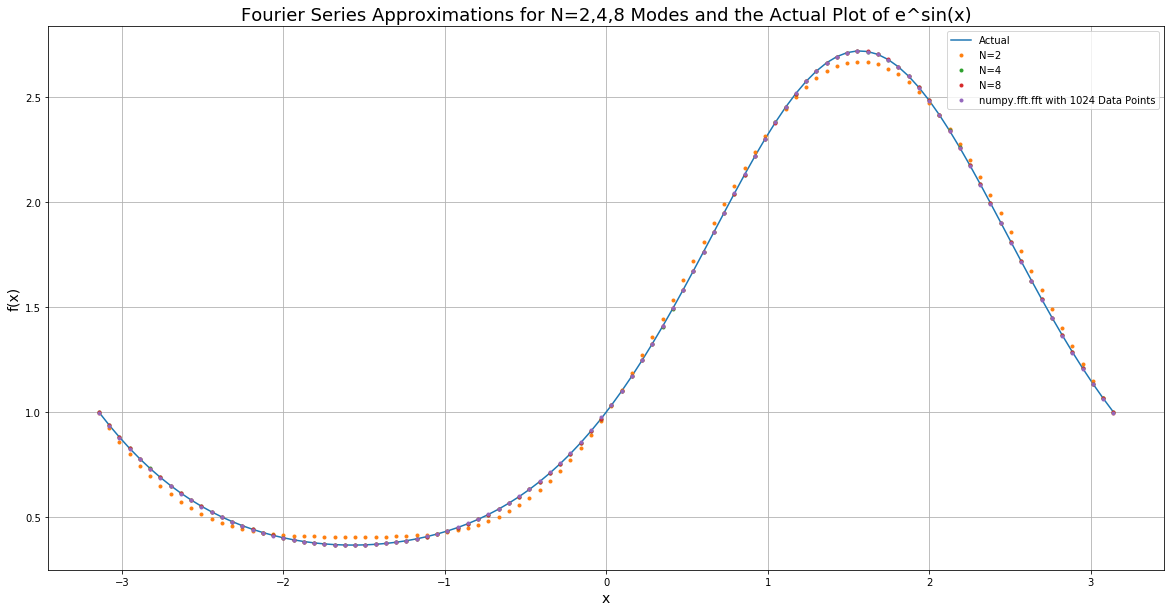

In [22]:
f = lambda x: np.exp(np.sin(x))
x1 = np.linspace(-np.pi,np.pi,100)
x = np.linspace(-np.pi,np.pi,1024)
plt.figure(figsize=(20,10))
plt.title('Fourier Series Approximations for N=2,4,8 Modes and the Actual Plot of e^sin(x)',fontsize=18)
plt.plot(x1,f(x1))
plt.plot(x1,np.real(FourierVals(x1,FourierFit(x,f,2))),'.') #High resolution in FourierFit for accurate Trapezoidal integration.
plt.plot(x1,np.real(FourierVals(x1,FourierFit(x,f,4))),'.')
plt.plot(x1,np.real(FourierVals(x1,FourierFit(x,f,8))),'.')
plt.plot(x1,np.real(FourierVals(x1,1/1024*np.fft.fft(f(-x)))),'.')
plt.xlabel('x',fontsize=14)
plt.ylabel('f(x)',fontsize=14)
plt.legend(["Actual","N=2","N=4","N=8", "numpy.fft.fft with 1024 Data Points"])
plt.grid()

Error as measured by the Euclidean norm of the difference:
For N = 2: 0.31437634632585826
For N = 4: 0.003833238122165435
For N = 8: 7.774927722491323e-08
For numpy.fft.fft with 1024 Data Points: 0.022507891964716968


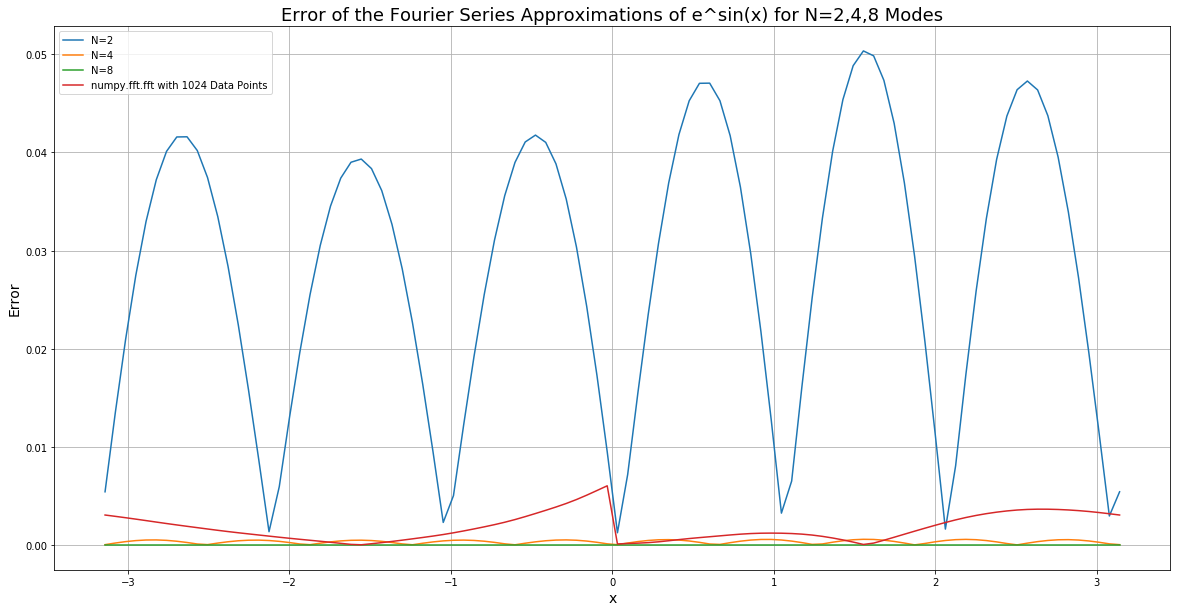

In [23]:
f = lambda x: np.exp(np.sin(x))
x1 = np.linspace(-np.pi,np.pi,100)
x = np.linspace(-np.pi,np.pi,1024)
plt.figure(figsize=(20,10))
plt.title('Error of the Fourier Series Approximations of e^sin(x) for N=2,4,8 Modes',fontsize=18)
N2 = np.real(FourierVals(x1,FourierFit(x,f,2)))-f(x1) #High resolution in FourierFit for accurate Trapezoidal integration.
N4 = np.real(FourierVals(x1,FourierFit(x,f,4)))-f(x1)
N8 = np.real(FourierVals(x1,FourierFit(x,f,8)))-f(x1)
Numpy = np.real(FourierVals(x1,1/1024*np.fft.fft(f(-x)))-f(x1))
plt.plot(x1,np.abs(N2))
plt.plot(x1,np.abs(N4))
plt.plot(x1,np.abs(N8))
plt.ylabel('Error',fontsize=14)
plt.xlabel('x',fontsize=14)
plt.plot(x1,np.abs(Numpy))
plt.legend(["N=2","N=4","N=8","numpy.fft.fft with 1024 Data Points"])
plt.grid()
print("Error as measured by the Euclidean norm of the difference:")
print("For N = 2:",np.linalg.norm(N2,2))
print("For N = 4:",np.linalg.norm(N4,2))
print("For N = 8:",np.linalg.norm(N8,2))
print("For numpy.fft.fft with 1024 Data Points:",np.linalg.norm(Numpy,2))

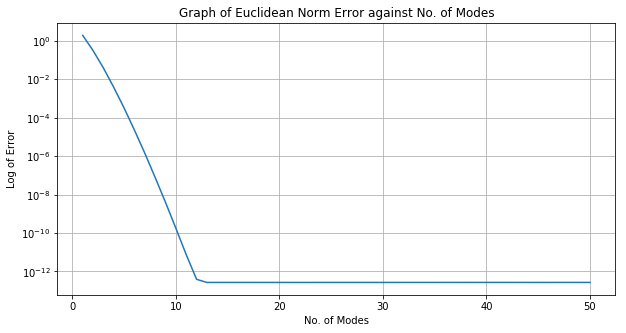

In [24]:
N = 50
Error = np.zeros(N)
for N in rangeE(1,N):
    Error[N-1] = np.linalg.norm(np.real(FourierVals(x1,FourierFit(x,f,N)))-f(x1),2)

plt.figure(figsize=(10,5))
plt.semilogy(rangeE(1,N),Error)
plt.title("Graph of Euclidean Norm Error against No. of Modes")
plt.xlabel('No. of Modes')
plt.ylabel('Log of Error')
plt.grid()

## Q5

In [62]:
def FourierVals_diff (x,f,N):
    L = max(x) - min(x)
    intervals = len(x)
    fHat = np.zeros(2*N+1, dtype = 'cfloat')
    fapprox = np.zeros(intervals, dtype = 'cfloat')
    for j in range(-N, N+1):
        integrand = np.sum(np.exp(-2*1j*j*np.pi*x/L)*f(x))-(f(x[0])*np.exp(-2*1j*j*np.pi*x[0]/L))
        fHat[j] = (x[1]-x[0])*integrand/L
        fapprox += (2*1j*j*np.pi/L)*np.exp(2*1j*j*np.pi*x/L)*fHat[j]
    return fapprox

In [63]:
def centered_d(f,x,h): #Centered-Difference, Order 2
    return (f(x+h)-f(x-h))/(2*h)

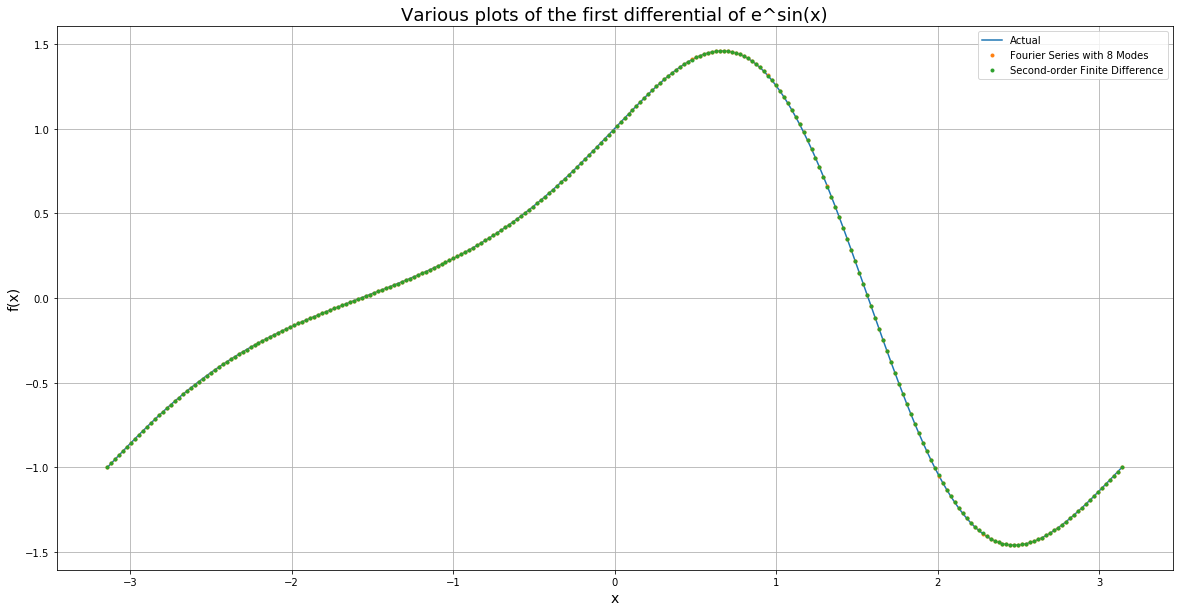

In [64]:
f = lambda x: np.exp(np.sin(x))
f_p = lambda x: np.cos(x)*np.exp(np.sin(x))
x = np.linspace(-np.pi,np.pi,256)
plt.figure(figsize=(20,10))
plt.title('Various plots of the first differential of e^sin(x)',fontsize=18)
plt.plot(x,f_p(x))
plt.plot(x,np.real(FourierVals_diff(x,f,8)),'.')
plt.plot(x,centered_d(f,x,x[1]-x[0]),'.')
plt.xlabel('x',fontsize=14)
plt.ylabel('f(x)',fontsize=14)
#plt.plot(x,np.real(FourierVals(x,1/256*np.fft.fft(-f_p(-x)))),'.')
plt.legend(["Actual","Fourier Series with 8 Modes","Second-order Finite Difference"])
plt.grid()

Error as measured by the Euclidean norm of the difference:
Fourier Series with 8 Modes: 1.127689321953802e-06
Second-order Finite Difference: 0.003140177901139921


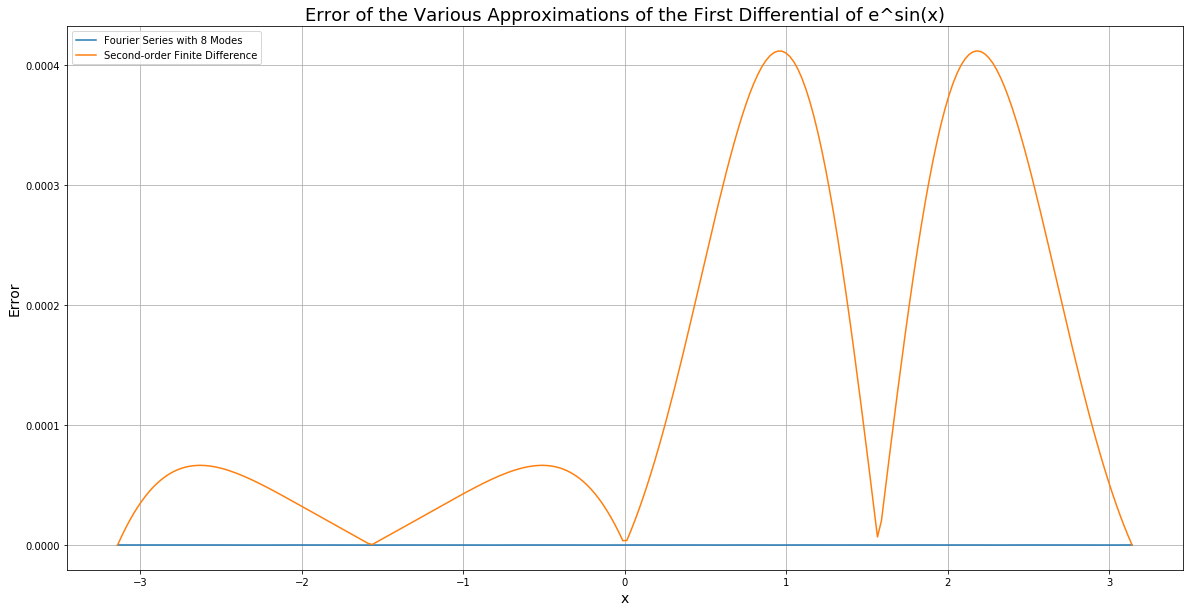

In [47]:
f = lambda x: np.exp(np.sin(x))
f_p = lambda x: np.cos(x)*np.exp(np.sin(x))
x = np.linspace(-np.pi,np.pi,256)
Fourier = np.real(FourierVals_diff(x,f,8))-f_p(x)
TwoFD = centered_d(f,x,x[1]-x[0])-f_p(x)
#FFT = np.real(FourierVals(x,1/256*np.fft.fft(-f_p(-x))))-f_p(x)
plt.figure(figsize=(20,10))
plt.title('Error of the Various Approximations of the First Differential of e^sin(x)',fontsize=18)
plt.plot(x,np.abs(Fourier))
plt.plot(x,np.abs(TwoFD))
plt.ylabel('Error',fontsize=14)
plt.xlabel('x',fontsize=14)
#plt.plot(x,np.abs(FFT))
plt.legend(["Fourier Series with 8 Modes","Second-order Finite Difference"])
plt.grid()
print("Error as measured by the Euclidean norm of the difference:")
print("Fourier Series with 8 Modes:",np.linalg.norm(Fourier,2))
print("Second-order Finite Difference:",np.linalg.norm(TwoFD,2))
#print("FFT",np.linalg.norm(FFT,2))

In [48]:
f = lambda x: np.exp(np.sin(x))
x = np.random.random(2**12)
%timeit FourierVals_diff(x,f,8) #6.34 ms ± 153 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
%timeit centered_d(f,x,x[1]-x[0]) #129 µs ± 2.04 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
#%timeit FourierVals(x,1/(2**12)*np.fft.fft(-f_p(-x)))

11.7 ms ± 264 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
128 µs ± 738 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


It appears that numerical differentiation with Fourier Series is both less accurate and slower than numerical differentiation with a second-order finite difference method.

## Q6

Define $\tilde f := \sum_{n=0}^{N} c_n T_n(x)$ for $x \in [ -1,1 ]$, let $\cos(\theta) = x \implies T_n(\theta) = cos(n\theta)$.
Then, we have
\begin{align}
\tilde f &= \sum_{n=0}^N c_n \cos(n\theta) \\
&= \sum_{n=0}^N c_n \frac{1}{2}(e^{in\theta} + e^{-in\theta}) \\
&= \sum_{n=0}^N c_n \frac{1}{2}(e^{in\theta}) + \sum_{n=-N}^0 c_n \frac{1}{2}(e^{in\theta}) \\
&= \frac{1}{2}\sum_{n=-N}^{N} c_n e^{in\theta} + \frac{1}{2}c_0 \mbox{ for } \theta \in [0, \pi].
\end{align}

Define the 2-norm between $f(x)$ and the projection $\tilde f(x)$ as $(D)^2 := \langle f(x) - \tilde f(x), f(x) - \tilde f(x) \rangle$. Therefore, by Q3(c),

$$\frac{d}{d c_j}(D)^2 = - 2\langle f,e^{-ij\theta}\rangle  + 2c_{-j}\langle e^{ij\theta}, e^{ij\theta} \rangle. $$

Due to the change of variable $x = \cos(\theta)$,
\begin{align}
\langle e^{ij\theta}, e^{ij\theta} \rangle &= \int_{\pi}^0  e^{ij\theta}\overline{e^{ij\theta}}\frac{1}{\sqrt{1-\cos^2(\theta)}}\frac{dx}{d\theta} d\theta\\
&= \int_{\pi}^0  e^{ij\theta}{e^{-ij\theta}}\frac{1}{\sqrt{1-\cos^2(\theta)}}(-\sin(\theta)) d\theta\\
&= \int_{\pi}^0  e^{ij\theta}{e^{-ij\theta}}\frac{1}{|\sin(\theta)|}(-\sin(\theta)) d\theta\\
&= \int_{\pi}^0  e^{ij\theta}{e^{-ij\theta}}\frac{1}{\sin(\theta)}(-\sin(\theta)) d\theta \mbox{ since for } 0 \leq \theta \leq \pi, sin(\theta) \geq 0 \\
&= \int_{\pi}^0 -1 d\theta = \pi.
\end{align}

Therefore,

$$\frac{d}{d c_j}(D)^2 = - 2\langle f,e^{-ij\theta}\rangle  + 2\pi c_{-j}.$$

Let $\frac{d}{d c_j}(D)^2 = 0$, then

$$2\langle f,e^{-ij\theta}\rangle = 2\pi c_{-j} \implies c_{-j} = \frac{1}{\pi}\langle f,e^{-ij\theta}\rangle \implies c_{j} = \frac{1}{\pi}\langle f,e^{ij\theta}\rangle.$$

$\frac{d}{d c}(D)^2 = 0$ is equivalent to
$$\forall j \in \mathbb{Z}, -N \leq j \leq N, \frac{d}{d c_j}(D)^2 = 0 \iff c_{j} = \frac{1}{\pi}\langle f,e^{ij\theta}\rangle \mbox{ for all $j$}.$$

Finally,

$$\forall j \in \mathbb{Z}, -N \leq j \leq N, \frac{d^2}{d c_j^2}(D)^2 = 2\pi > 0 \implies \mbox{ the $c_{j}$'s minimise $(D)^2$}.$$